# Теория вероятностей и математическая статистика

## Дополнительно: введение в иерархический кластерный анализ

*Алла Тамбовцева, НИУ ВШЭ* 

### Часть 1: используем готовые функции Python

Попробуем воспроизвести действия по реализации иерархического кластерного анализа в задаче из семинарского листочка. Итак, у нас есть данные по четырём наблюдениям:

<table>
    <tr><th>X</th><th>Y</th></tr>
    <tr><td>0</td><td>4</td></tr>
    <tr><td>7</td><td>0</td></tr>
    <tr><td>1</td><td>2</td></tr>
    <tr><td>4</td><td>2</td></tr>
</table>

Необходимо реализовать иерархический кластерный анализ, выбрав в качестве метрики **манхэттенское расстояние** и **метод дальнего соседа** в качестве метода агрегирования. Импортируем библиотеку `numpy` и сохраним данные в виде двух массивов:

In [1]:
import numpy as np

In [2]:
# данные
x = np.array([0, 7, 1, 4])
y = np.array([4, 0, 2, 2])
print(x, y)

[0 7 1 4] [4 0 2 2]


Перед вычислением расстояний данные необходимо центрировать (вычесть среднее) и нормировать (поделить результат на стандартное отклонение). Вычислим средние выборок:

In [3]:
print(x.mean())
print(y.mean())

3.0
2.0


Вычислим стандартные отклонения выборок. По умолчанию в NumPy используется формула с делением на $n$, чтобы получить привычное деление на $n-1$, добавляем аргумент `ddof = 1`:

In [4]:
# ddof - degrees of freedom
# .round() – сразу округляем до целых, как на семинаре

print(x.std(ddof = 1).round())
print(y.std(ddof = 1).round())

3.0
2.0


Выполняем стандартизацию – массивы позволяют производить операции сразу со всеми элементами массива без циклов:

In [5]:
# как на семинаре округляем итог до 1 знака после запятой

x_norm = ((x - x.mean()) / x.std(ddof = 1).round()).round(2)
y_norm = ((y - y.mean()) / y.std(ddof = 1).round()).round(2)

print(x_norm)
print(y_norm)

[-1.    1.33 -0.67  0.33]
[ 1. -1.  0.  0.]


Для удобства объединяем два массива в один – по столбцам:

In [6]:
# column_stack() – по столбцам
# на входе – либо список, либо кортеж

A = np.column_stack((x_norm, y_norm))
A

array([[-1.  ,  1.  ],
       [ 1.33, -1.  ],
       [-0.67,  0.  ],
       [ 0.33,  0.  ]])

Для реализации иерархического кластерного анализа нам понадобится набор функций `hierarchy` из модуля `cluster` библиотеки `scipy` (от *Scientific Python*):

In [7]:
from scipy.cluster import hierarchy

Для получения результатов воспользуемся функцией `linkage()`, она принимает на вход:

* данные (массив или более привычный датафрейм)
* метод агрегирования (аргумент `method`)
* меру расстояния (аргумент `metric`)

и возвращает результаты, необходимые для последующего построения дендрограммы. 

По умолчанию эта функция использует **евклидово расстояние** (`metric='euclidean'`) и **метод ближнего соседа**, он же метод одиночной связи (`method='single'`). Полный список значений `metric` можно найти [здесь](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist), список методов агрегирования – [здесь](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). Нам нужно **манхэттенское расстояние** и **метод дальнего соседа**:

In [8]:
# манхэттенское расстояние = блочное = cityblock
# метод дальнего соседа = метод полной связи = complete

hc = hierarchy.linkage(A, method = "complete", metric = "cityblock")

В каком виде функция `linkage()` возвращает результаты?

In [9]:
hc

array([[2.  , 3.  , 1.  , 2.  ],
       [0.  , 4.  , 2.33, 3.  ],
       [1.  , 5.  , 4.33, 4.  ]])

В виде специфического массива размерности $(n-1)$ на 4, где $n$ – число наблюдений. Каждая строчка последовательно описывает каждый этап иерархической кластеризации – объединения точек. Чтобы понять, что представляют значения в этих строчках, построим дендрограмму – вызовем функцию `dendrogram()`:

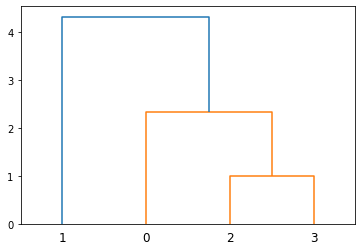

In [10]:
hierarchy.dendrogram(hc);

Первая строчка в `hc` описывает следующее: точка под номером 2 объединяется с точкой под номером 3 на расстоянии 1 в кластер, в этом кластере в итоге находятся два наблюдения. Вторая строчка в `hc` описывает следующий этап кластеризации: точка под номером 0 присоединяется к кластеру под номером 4 (Python сам пронумеровал созданный ранее кластер, точки имеют индексы от 0 до 3, он взял следующее число) на расстоянии 2.3, итого в кластере уже три наблюдения. Третья строка соответствует завершающему этапу кластеризации – точка под номером 1 присодиняется к вновь образованному кластеру под номером 5 (номер 4 уже был) на расстоянии 4.3, всего в этом большом кластере четыре точки, все наблюдения задействованы, объединение завершено.

Как обычно, дендрограмма показывает все возможные разбиения на кластеры, но Python ещё сам «подсвечивает» цветом, какие группы будет разумно выделить. Здесь он намекает на то, что деление на группы можно провести по некоторому расстоянию, чтобы получить кластер из одной точки (синий цвет) и кластер из трёх точек (оранжевый цвет). Для получения такого разбиения по умолчанию используется значение 
`0.7 * max(hc[:, 2])`, где `max(hc[:, 2])` – максимальное из расстояний между кластерами, которое находится в третьем столбце `hc`. В нашем примере это 0.7 * 4.3 = 3.01. В целом, на эти значения можно ориентироваться, но всё же тут многое зависит от нашей задачи и содержательной информации о данных.

Это пороговое значение для выделения кластеров можно менять – так как от него зависят цвета, аргумент называется `color_threshold`:

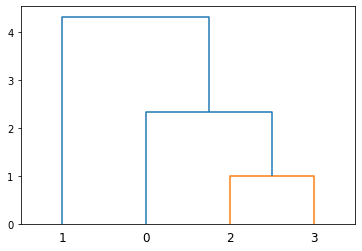

In [11]:
# три кластера, два по одному наблюдению
# и один – из двух наблюдений

hierarchy.dendrogram(hc, color_threshold = 1.5);

При желании добавление разных цветов можно выключить (`color_threshold = 0`) и просто добавить горизонтальную линию. Для этого импортируем модуль `pyplot` из библиотеки `matplotlib` для графики:

In [12]:
from matplotlib import pyplot as plt

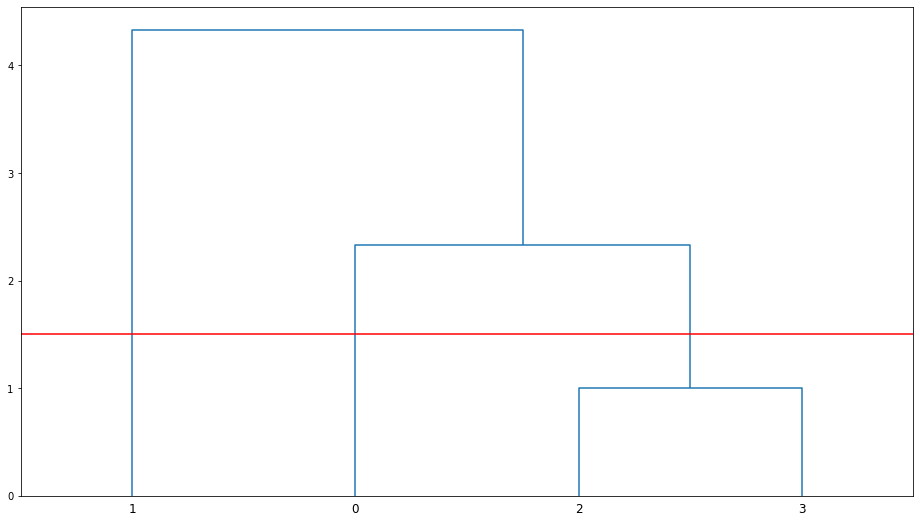

In [13]:
# резервируем место под график 16 на 9 дюймов
# строим дендрограмму, в тех же осях добавляем горизонтальную линию (hlines)
# линия на уровне y = 1.5 красного цвета 
# xmin и xmax – границы по оси X

plt.figure(figsize = (16, 9))
hierarchy.dendrogram(hc, color_threshold = 0)
plt.hlines(y = 1.5, xmin = 0, xmax = 50, color = "red");

Для полного счастья можем сделать линию пунктирной (аргумент `linestyle`) и добавить точки в местах «разрезания» дендрограммы:

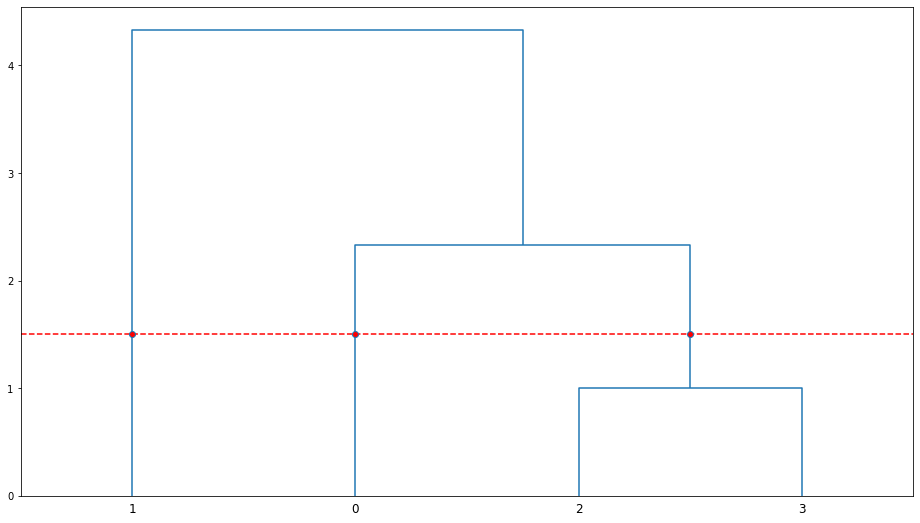

In [14]:
plt.figure(figsize = (16, 9))
hierarchy.dendrogram(hc, color_threshold = 0)
plt.hlines(y = 1.5, xmin = 0, xmax = 50, color = "red", linestyle = "dashed");

# на первом и втором местах – координаты точек по осям x и y
# marker – тип точки, color – цвет точки, markeredgecolor – цвет границ точки

plt.plot(5, 1.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");
plt.plot(15, 1.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");
plt.plot(30, 1.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");

Откуда взялись значения в `plot()`? Это координаты на основе точек для соединительных линий, сохранённых в объекте, который создаётся при построении дендрограммы. Если после строки с кодом для дендрограммы не ставить точку с запятой, мы его увидим:

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5]],
 'dcoord': [[0.0, 1.0, 1.0, 0.0],
  [0.0, 2.33, 2.33, 1.0],
  [0.0, 4.33, 4.33, 2.33]],
 'ivl': ['1', '0', '2', '3'],
 'leaves': [1, 0, 2, 3],
 'color_list': ['C1', 'C1', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C1']}

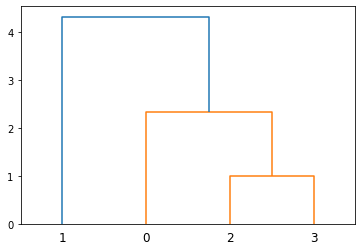

In [15]:
# icoord и dcoord – координаты для соединительных линий (веток дендрограммы)
hierarchy.dendrogram(hc)

Тут сложновато, разберём несколько точек. Возьмём первые два значения в первом списке в `icoord` и `dcoord`, это [25.0, 25.0] и [0.0, 1.0]. Если сформировать пары (25, 0) и (25, 1), получим две точки, если соединим эти точки на дендрограмме, получится вертикальная линия для «листика» с наблюдением под номером 2. Если проделаем это для следующих двух значений в тех же списках, получим точки (35, 1) и (35, 0), соединим их – получим вертикальную линию для «листика» с наблюдением под номером 3. Вторые списки в `icoord` и `dcoord` описывают вертикальные ветки для соединения точки 0 и кластера из точек 2 и 3, третьи – вертикальные ветки для соединения точки 1 и кластера из точек 0, 2 и 3. Горизонтальные линии далее отрисовываются автоматически. 

Теперь, если вернуться к координатам для красных точек на предыдущей дендрограмме, должно стать понятнее, почему значения по оси X именно 5, 15 и 30 :) А про типы и настройки точек можно почитать [здесь](https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html).

Ну, и для полного-полного счастья заменим индексы точек на какие-то свои названия (метки `labels`) и выгрузим дендрограмму в png-файл:

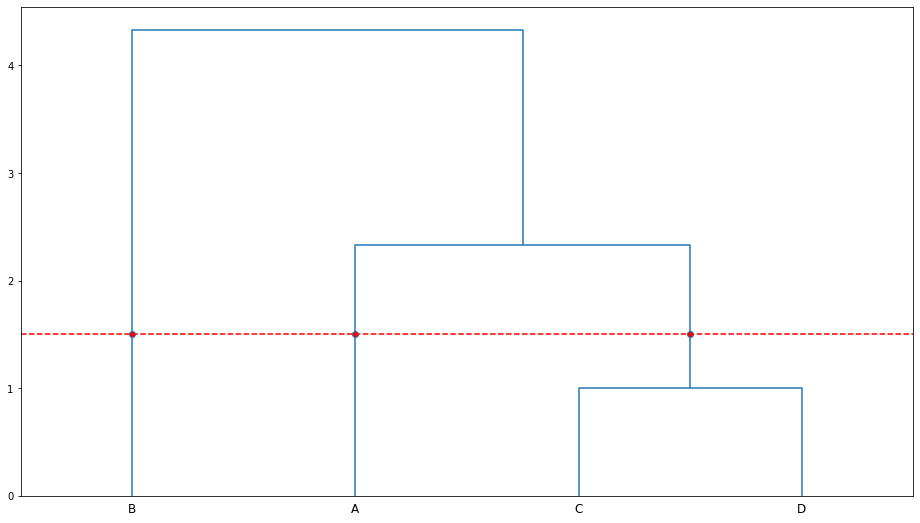

In [16]:
plt.figure(figsize = (16, 9))
hierarchy.dendrogram(hc, color_threshold = 0, labels = ["A", "B", "C", "D"])

plt.hlines(y = 1.5, xmin = 0, xmax = 50, color = "red", linestyle = "dashed");
plt.plot(5, 1.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");
plt.plot(15, 1.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");
plt.plot(30, 1.5, marker = 'o', color = "red", markeredgecolor = "tab:blue");

plt.savefig("example00.png")

### Часть 2: используем свои матрицы расстояний (дополнительно)

Иногда возникает необходимость использовать уже готовые матрицы расстояний для дальнейшей реализации кластерного анализа. Это может быть связано с разными причинами: разработали свою метрику, которой нет в Python, нашли готовые данные по расстояниям для большого массива данных в интернете (пересчитывать заново затратно с точки зрения затрат времени и памяти), хочется проверить домашнее задание с учётом разных округлений... Глобальных проблем нет, но есть одна особенность функции `linkage()`, которую нужно учесть.

Давайте для полноты картины создадим свою матрицу расстояний с нуля. Но функции для вычисления расстояний свои писать не будем – воспользуемся набором функций `distance` из модуля `spatial` внутри `scipy`:

In [17]:
from scipy.spatial import distance

В массиве `A`у нас четыре точки, значит, матрица расстояний будет иметь размер четыре на четыре. Зафиксируем это автоматически – вычислим форму массива `A`:

In [18]:
# число строк и число столбцов
print(A.shape)

(4, 2)


С помощью функции `zeros()` из библиотеки `numpy` создадим матрицу расстояний из одних нулей, чтобы потом аккуратно заполнить её в цикле:

In [19]:
D = np.zeros((A.shape[0], A.shape[0]))
D

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Для вычисления манхэттенского расстояния мы будем использовать функцию `cityblock()` из набора `distance`:

In [20]:
# i и j – номера наблюдений, оба от 0 до 4
# мы вычисляем расстояния между наблюдениями с номерами i и j в A
# и помещаем ответ в матрицу D в i-ую строку и j-ый столбец

for i in range(0, A.shape[0]):
    for j in range(0, A.shape[0]):
        D[i, j] = distance.cityblock(A[i], A[j]) 
D

array([[0.  , 4.33, 1.33, 2.33],
       [4.33, 0.  , 3.  , 2.  ],
       [1.33, 3.  , 0.  , 1.  ],
       [2.33, 2.  , 1.  , 0.  ]])

Такой способ получения матрицы расстояний вполне понятный, но неэффективный, а для огромного числа наблюдений просто убийственный! Во-первых, мы всё равно вычисляем нулевые расстояния на главной диагонали матрицы – хорошо бы добавить условие `if i != j`, чтобы нули на диагонали остались ещё с момента заполнения нулями, не обновлялись. Во-вторых, мы считаем расстояния между точками по два раза, не пользуясь симметричностью – ещё лучше добавить условие `if i > j` или `if i < j` и посчитать всего 6 различных расстояний. 

Так вот, Python, конечно, действует более рационально, поэтому функция `linkage()` внутри использует не полную матрицу расстояний, а её компактную версию. Что будет, если мы подадим ей на вход нашу матрицу `D`, верную, но избыточную?

In [21]:
# метрику не прописываем – расстояния уже готовые
# а метод агрегирования по-прежнему обязателен

hierarchy.linkage(D, method = 'complete')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


array([[2.        , 3.        , 2.        , 2.        ],
       [0.        , 4.        , 4.04914806, 3.        ],
       [1.        , 5.        , 6.3557533 , 4.        ]])

Python выдал какой-то результат, не совсем корректный, и при этом вывел сообщение про «подозрительную» матрицу, которая выглядит как *uncondensed distance matrix*, то есть матрица расстояний в некомпактной форме. Как получить компактную форму (и заодно увидеть, какая она)? Воспользоваться функцией `squareform()` из того же набора `distance`:  

In [22]:
distance.squareform(D)

array([4.33, 1.33, 2.33, 3.  , 2.  , 1.  ])

Итак, всё просто: компактная форма матрицы расстояний – это просто набор её значений над главной диагональю! Что удобно, функция `squareform()` работает в две стороны: она может и симметричную матрицу свернуть в компактный вид, и компактную форму преобразовать в поноценную квадратную матрицу (она сама распознаёт, что ей подано на вход):

In [23]:
# для иллюстрации – применяем функцию дважды
# из короткой формы выше получили снова большую матрицу

distance.squareform(distance.squareform(D))

array([[0.  , 4.33, 1.33, 2.33],
       [4.33, 0.  , 3.  , 2.  ],
       [1.33, 3.  , 0.  , 1.  ],
       [2.33, 2.  , 1.  , 0.  ]])

Финальный аккорд – подставляем компактную форму нашей матрицы в `linkage()` и сравниваем результаты с «автоматикой»:

In [24]:
hc2 = hierarchy.linkage(distance.squareform(D), method = 'complete')
hc2

array([[2.  , 3.  , 1.  , 2.  ],
       [0.  , 4.  , 2.33, 3.  ],
       [1.  , 5.  , 4.33, 4.  ]])

In [25]:
hc

array([[2.  , 3.  , 1.  , 2.  ],
       [0.  , 4.  , 2.33, 3.  ],
       [1.  , 5.  , 4.33, 4.  ]])

Совпало! А значит, мы точно знаем, что порядок действий правильный, и матрицу `D` мы можем формировать каким-то более интересным образом.